## Loading Data

In [6]:
import pandas as pd
import datetime
import seaborn as sns
from scipy import stats
import numpy as np
import random

In [3]:
filename = "./../data/311_Cases.csv"

In [4]:
data = pd.read_csv(filename, encoding='utf8',engine='python').dropna()

In [5]:
# quick inspection
len(data) # 3,362,678
data.head()

,CaseID,Opened,Closed,Updated,Status,Status Notes,Responsible Agency,Category,Request Type,Request Details,Address,Supervisor District,Neighborhood,Police District,Latitude,Longitude,Point,Source,Media URL
24810,3135216,12/05/2013 02:50:24 PM,06/25/2018 09:50:55 AM,06/25/2018 09:50:55 AM,Closed,Found 40 square feet of damaged/uneven sidewal...,DPW BSM Queue,Sidewalk or Curb,Sidewalk_Defect,Collapsed_sidewalk,"920 VAN NESS AVE, SAN FRANCISCO, CA, 94109",6.0,Tenderloin,NORTHERN,37.78418,-122.4208,"(37.78416124, -122.42081673)",Mobile/Open311,http://mobile311.sfgov.org/media/san_francisco...
86201,4203877,11/12/2014 08:46:11 PM,06/25/2018 10:38:19 AM,06/25/2018 10:38:19 AM,Closed,9 Sumner St: damaged sidewalk around utility v...,DPW BSM Queue,Sidewalk or Curb,Sidewalk_Defect,Collapsed_sidewalk,"10 SUMNER ST, SAN FRANCISCO, CA, 94103",6.0,South of Market,SOUTHERN,37.77632,-122.4106,"(37.77629119, -122.41061191)",Mobile/Open311,http://mobile311.sfgov.org/media/san_francisco...
86582,4223752,11/19/2014 10:48:56 AM,06/25/2018 10:22:00 AM,06/25/2018 10:22:00 AM,Closed,2515-2565 Bay Shore Blvd: damaged sidewalk nex...,DPW BSM Queue,Sidewalk or Curb,Sidewalk_Defect,Collapsed_sidewalk,Intersection of BAY SHORE BLVD and SUNNYDALE AVE,10.0,Little Hollywood,INGLESIDE,37.70903,-122.4048,"(37.70885355, -122.4051094)",Mobile/Open311,http://mobile311.sfgov.org/media/san_francisco...
100891,10303151,01/01/2019 10:10:00 PM,01/08/2019 05:46:00 AM,01/08/2019 05:46:00 AM,Closed,01/07/2019 VEH GOA @1033 HOURS #338,DPT Abandoned Vehicles Work Queue,Abandoned Vehicle,Abandoned Vehicles,DPT Abandoned Vehicles Low,"1097 OAKDALE AVE, SAN FRANCISCO, CA, 94124",10.0,Hunters Point,BAYVIEW,37.72940,-122.3813,"(37.72939344, -122.38131978)",Web,http://mobile311.sfgov.org/media/san_francisco...
140933,10303744,01/02/2019 08:20:00 AM,01/08/2019 07:39:00 AM,01/08/2019 07:39:00 AM,Closed,01/07/2019 @1349 HRS #168,DPT Abandoned Vehicles Work Queue,Abandoned Vehicle,Abandoned Vehicles,DPT Abandoned Vehicles Low,Intersection of MALTA DR and VALLETTA CT,7.0,Miraloma Park,INGLESIDE,37.73619,-122.4444,"(37.7362185, -122.4444058)",Mobile/Open311,http://mobile311.sfgov.org/media/san_francisco...


## Downsize data

In [34]:
# set random seed
random.seed(42)
small_data = data.sample(n = int(len(data) * 0.1)) # keep 10%
len(small_data) # 336,267

53957

## Select relevant variables
Remember, the goal is to predict how long it takes to close a case, given neighborhood and category of complaint

In [35]:
# note: might want to move Category to Request Type?
X = small_data[["Latitude", "Longitude" ]] #, "Category"]] # explanatory variables

In [38]:
# NOTE: this takes some time
timedelta = pd.to_datetime(small_data["Closed"]) - pd.to_datetime(small_data["Opened"])
small_data["ClosingTime"] = timedelta.dt.days
Y = small_data["ClosingTime"] # target variable

In [39]:
len(small_data)

53957

# Outlier Detection: Visual Methods

/home/louiselai88gmail/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/louiselai88gmail/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


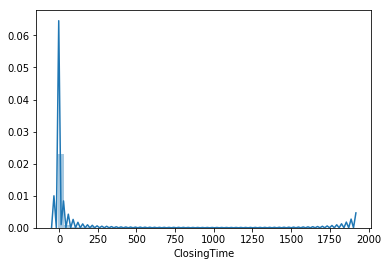

In [40]:
sns.distplot(small_data.ClosingTime) # trash

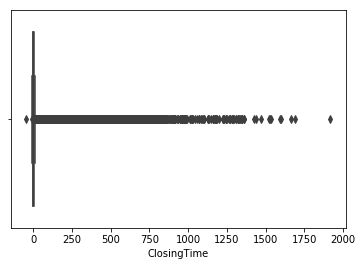

In [41]:
sns.boxplot(x="ClosingTime", data=small_data) # trash also

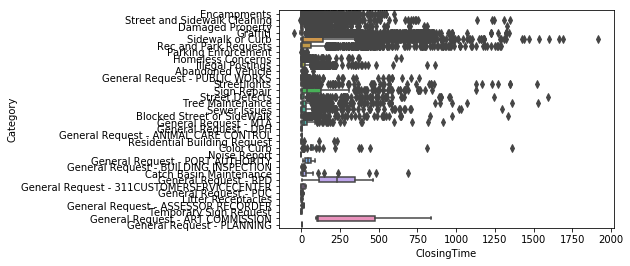

In [42]:
sns.boxplot(x="ClosingTime", y="Category", data=small_data) # not very helpful visually. Too many categories!

In [43]:
# visualizing the top categories only
small_data.groupby("Category").count().sort_values(by=['CaseID'], ascending=False).head(9) # it was observerd that after 10, the numbers dropped

,CaseID,Opened,Closed,Updated,Status,Status Notes,Responsible Agency,Request Type,Request Details,Address,Supervisor District,Neighborhood,Police District,Latitude,Longitude,Point,Source,Media URL,ClosingTime
Category,,,,,,,,,,,,,,,,,,,
Street and Sidewalk Cleaning,19962,19962,19962,19962,19962,19962,19962,19962,19962,19962,19962,19962,19962,19962,19962,19962,19962,19962,19962
Graffiti,13352,13352,13352,13352,13352,13352,13352,13352,13352,13352,13352,13352,13352,13352,13352,13352,13352,13352,13352
Encampments,5398,5398,5398,5398,5398,5398,5398,5398,5398,5398,5398,5398,5398,5398,5398,5398,5398,5398,5398
Abandoned Vehicle,2306,2306,2306,2306,2306,2306,2306,2306,2306,2306,2306,2306,2306,2306,2306,2306,2306,2306,2306
Homeless Concerns,2002,2002,2002,2002,2002,2002,2002,2002,2002,2002,2002,2002,2002,2002,2002,2002,2002,2002,2002
Illegal Postings,1491,1491,1491,1491,1491,1491,1491,1491,1491,1491,1491,1491,1491,1491,1491,1491,1491,1491,1491
Rec and Park Requests,1215,1215,1215,1215,1215,1215,1215,1215,1215,1215,1215,1215,1215,1215,1215,1215,1215,1215,1215
Parking Enforcement,1191,1191,1191,1191,1191,1191,1191,1191,1191,1191,1191,1191,1191,1191,1191,1191,1191,1191,1191
Sidewalk or Curb,1071,1071,1071,1071,1071,1071,1071,1071,1071,1071,1071,1071,1071,1071,1071,1071,1071,1071,1071


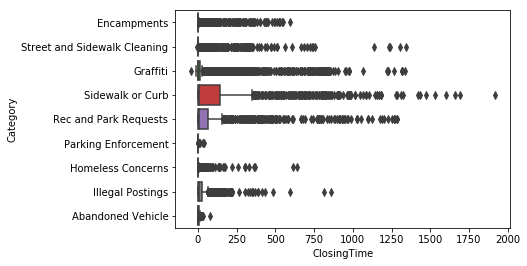

In [44]:
top_categories = ["Street and Sidewalk Cleaning", "Graffiti", "Encampments",
                 "Abandoned Vehicle", "Homeless Concerns", "Illegal Postings",
                  "Rec and Park Requests", "Parking Enforcement", "Parking Enforcement",
                  "Sidewalk or Curb"]

top_small_data = small_data[small_data["Category"].isin(top_categories, )]

sns.boxplot(x="ClosingTime", y="Category", data=top_small_data)

# the boxplot is still bad. Thus, we turn to statistical methods

# Outlier Detection 2: Statistical Methods

In [18]:
z = np.abs(stats.zscore(small_data['ClosingTime'])) # gives us the z-score for each closing time
threshold = 3 # standard deviations

data_reduced = small_data[(z < threshold)] # 
outliers = small_data[(z >= threshold)]

print("Within 3 s.d's       : {}".format(len(data_reduced)))
print("Greather than 3 s.d's: {}".format(len(outliers)))
print("Total                : {}".format(len(small_data)))

# Thus, we've now removed 963 rows of outlier data
# Success!

Within 3 s.d's       : 52994
Greather than 3 s.d's: 963
Total                : 53957


# Plotting, again

/home/louiselai88gmail/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/louiselai88gmail/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


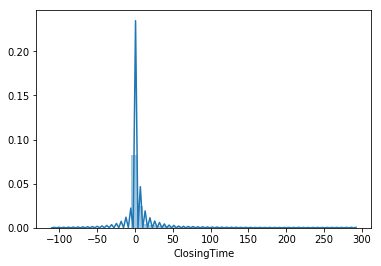

In [19]:
# After successfully removing outliers, we plot again
sns.distplot(data_reduced.ClosingTime) 

# .. well. We see that there is simply a huge concentration around 
# zero days for closing time. We have to live with this for now.

# Prediction, finally

In [20]:
from sklearn.model_selection import train_test_split

In [ ]:
# first, let us try without outlier removal

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)

# KNN

In [22]:
from sklearn.neighbors import KNeighborsClassifier

In [23]:
clf_2 = KNeighborsClassifier(n_neighbors=5)
clf_2.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [24]:
from sklearn.metrics import accuracy_score
y_pred_2 = clf_2.predict(X_test)
accuracy_score(y_test,y_pred_2)

# not great. Moving on to add more categorical variables.

0.45490284173873974

# KNN with categorical variables
(still with no outlier removal, yet)

In [46]:
# note: might want to move Category to Request Type?
# also, we are using 'top small data'
X = top_small_data[["Latitude", "Longitude", "Category"]] # explanatory variables

categories_nums = {"Category": {"Street and Sidewalk Cleaning" : 1,
                                  "Graffiti" :10, 
                                  "Encampments" : 2,
                                  "Abandoned Vehicle": 3, 
                                  "Homeless Concerns": 4, 
                                  "Illegal Postings": 5,
                                  "Rec and Park Requests": 6, 
                                  "Parking Enforcement": 7, 
                                  "Parking Enforcement": 8,
                                  "Sidewalk or Curb": 9}
                  }

top_small_data.replace(categories_nums, inplace = True)
top_small_data.head()

# succesfully replaced

/home/louiselai88gmail/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


,CaseID,Opened,Closed,Updated,Status,Status Notes,Responsible Agency,Category,Request Type,Request Details,Address,Supervisor District,Neighborhood,Police District,Latitude,Longitude,Point,Source,Media URL,ClosingTime
2441062,9034956,05/22/2018 01:14:29 PM,05/22/2018 02:24:29 PM,05/22/2018 02:24:29 PM,Closed,Pickup completed.,Recology_Abandoned,2,Encampment items,Cart Pickup,"1 TRAINOR ST, SAN FRANCISCO, CA, 94103",9.0,Mission,MISSION,37.76926,-122.4143,"(37.76950468, -122.41442734)",Mobile/Open311,http://mobile311.sfgov.org/media/san_francisco...,0
3275523,9178698,06/24/2018 12:38:26 PM,06/24/2018 01:18:00 PM,06/24/2018 01:18:00 PM,Closed,Private container,Recology_Overflowing,1,City_garbage_can_overflowing,City_garbage_can_overflowing,Intersection of HOLLY PARK CIR and APPLETON AVE,9.0,Holly Park,INGLESIDE,37.73755,-122.4208,"(37.73761065, -122.42091)",Mobile/Open311,http://mobile311.sfgov.org/media/san_francisco...,0
2189925,6628465,12/14/2016 01:29:43 PM,12/28/2016 03:31:23 AM,12/28/2016 03:31:23 AM,Closed,Per PSA manager: Graffiti has been abated.,RPD Park Service Area 5 Queue,10,Graffiti on Other_enter_additional_details_below,Other_enter_additional_details_below - Offensive,"Corona Heights, , SAN FRANCISCO, CA, 94114",8.0,Corona Heights,PARK,37.76460,-122.4370,"(37.765, -122.439)",Mobile/Open311,http://mobile311.sfgov.org/media/san_francisco...,13
1737550,5382979,12/17/2015 09:17:30 AM,12/17/2015 10:36:52 AM,12/17/2015 10:36:52 AM,Closed,resolved: Pickup completed,Recology_Abandoned,1,City_garbage_can_overflowing,City_garbage_can_overflowing,"566 FELL ST, SAN FRANCISCO, CA, 94102",5.0,Hayes Valley,NORTHERN,37.77578,-122.4275,"(37.775491467901, -122.427242949599)",Mobile/Open311,http://mobile311.sfgov.org/media/san_francisco...,0
2254688,9299071,07/22/2018 08:56:30 AM,07/25/2018 12:00:00 AM,07/25/2018 12:00:00 AM,Closed,No Action Described,DPW BSM Queue,9,Sidewalk_Defect,Lifted_sidewalk_other,"1298 POTRERO AVE, SAN FRANCISCO, CA, 94110",9.0,Mission,MISSION,37.75148,-122.4064,"(37.75153725, -122.40638213)",Mobile/Open311,http://mobile311.sfgov.org/media/san_francisco...,2


In [47]:
# nothing in this cell is new, we're just using the updated dataframe
# that contains categorical variables
# train test split, again

X = top_small_data[["Latitude", "Longitude", "Category"]] # explanatory variables
Y = top_small_data["ClosingTime"] # target variable

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)
clf_2 = KNeighborsClassifier(n_neighbors=5)

clf_2.fit(X_train,y_train)
y_pred_2 = clf_2.predict(X_test)
accuracy_score(y_test,y_pred_2)

# improved!!!! Went to ~50%!

0.5085559133674307